In [1]:
# https://www.kaggle.com/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner

# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [17]:
from keras.applications.vgg16 import VGG16
from tensorflow import keras

In [18]:
model = VGG16(weights='imagenet')

In [22]:
import tensorflow as tf
import numpy as np
import pathlib

# step 1
IMAGE_PATHS_DIR = 
# IMAGE_PATHS_DIR = 

paths = np.array([x.__str__() for x in pathlib.Path(IMAGE_PATHS_DIR).rglob('*.bmp')])
filenames = tf.constant(paths)

labels_array = np.array([x.split("\\")[-1].split("_")[0] for x in paths])
labels = tf.constant(labels_array)

n_clases = np.max([int(i) for i in labels_array])

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

dataset_len = len(dataset)

print(f"Dataset len: {dataset_len}")

train_size = int(0.7 * dataset_len)
test_size = int(0.30 * dataset_len)

print(f"train size: {train_size}")
print(f"test size: {test_size}")

def _parse_function(filename, label):
    img = tf.io.read_file(filename)
    image = tf.image.decode_bmp(img, channels = 3)
    label = int(label)
    return image, label

dataset = dataset.shuffle(dataset_len, seed=42)
dataset = dataset.map(_parse_function)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))


def label_preprocess(image, label):
    label = tf.one_hot(label-1, n_clases) 
    return image, label

train_ds = train_ds.map(
    label_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)

batch_size = 64
batch_size = 1


train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(label_preprocess)
test_ds = test_ds.batch(batch_size=batch_size, drop_remainder=True)

Dataset len: 14
train size: 9
test size: 4


In [23]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

outputs = VGG16(include_top=True, weights=None, classes=n_clases)(inputs)
model = keras.Model(inputs, outputs)

model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [24]:
epochs = 5  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

Epoch 1/5
9/9 - 19s - loss: 1320.9595 - accuracy: 0.3333 - val_loss: 0.8039 - val_accuracy: 0.4000 - 19s/epoch - 2s/step
Epoch 2/5
9/9 - 10s - loss: 2.2028 - accuracy: 0.5556 - val_loss: 0.6877 - val_accuracy: 0.6000 - 10s/epoch - 1s/step
Epoch 3/5
9/9 - 10s - loss: 0.7157 - accuracy: 0.4444 - val_loss: 0.7313 - val_accuracy: 0.4000 - 10s/epoch - 1s/step
Epoch 4/5
9/9 - 10s - loss: 0.7065 - accuracy: 0.6667 - val_loss: 0.6571 - val_accuracy: 0.8000 - 10s/epoch - 1s/step
Epoch 5/5
9/9 - 10s - loss: 0.6811 - accuracy: 0.6667 - val_loss: 0.6801 - val_accuracy: 0.6000 - 10s/epoch - 1s/step


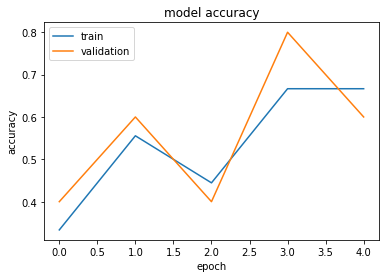

In [25]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [27]:
from tensorflow.keras import layers


def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    model = VGG16(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [28]:
model = build_model(num_classes=n_clases)

epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

Epoch 1/10
9/9 - 3s - loss: 0.7380 - accuracy: 0.4444 - val_loss: 2.4632 - val_accuracy: 0.6000 - 3s/epoch - 347ms/step
Epoch 2/10
9/9 - 2s - loss: 0.7054 - accuracy: 0.3333 - val_loss: 1.9724 - val_accuracy: 0.4000 - 2s/epoch - 189ms/step
Epoch 3/10
9/9 - 2s - loss: 0.7404 - accuracy: 0.4444 - val_loss: 0.6503 - val_accuracy: 0.6000 - 2s/epoch - 218ms/step
Epoch 4/10
9/9 - 2s - loss: 0.7097 - accuracy: 0.3333 - val_loss: 0.5480 - val_accuracy: 0.8000 - 2s/epoch - 213ms/step
Epoch 5/10
9/9 - 2s - loss: 0.7163 - accuracy: 0.4444 - val_loss: 0.3723 - val_accuracy: 0.8000 - 2s/epoch - 185ms/step
Epoch 6/10
9/9 - 2s - loss: 0.7473 - accuracy: 0.2222 - val_loss: 0.5175 - val_accuracy: 0.6000 - 2s/epoch - 207ms/step
Epoch 7/10
9/9 - 2s - loss: 0.7115 - accuracy: 0.3333 - val_loss: 0.5353 - val_accuracy: 0.6000 - 2s/epoch - 226ms/step
Epoch 8/10
9/9 - 2s - loss: 0.7226 - accuracy: 0.3333 - val_loss: 0.3283 - val_accuracy: 0.8000 - 2s/epoch - 227ms/step
Epoch 9/10
9/9 - 2s - loss: 0.7646 - acc

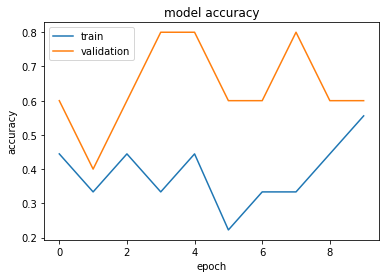

In [29]:
plot_hist(hist)

Epoch 1/5
9/9 - 6s - loss: 0.6715 - accuracy: 0.5556 - val_loss: 1.1289 - val_accuracy: 0.2000 - 6s/epoch - 651ms/step
Epoch 2/5
9/9 - 5s - loss: 0.6711 - accuracy: 0.5556 - val_loss: 1.1891 - val_accuracy: 0.4000 - 5s/epoch - 577ms/step
Epoch 3/5
9/9 - 5s - loss: 0.7018 - accuracy: 0.5556 - val_loss: 0.4253 - val_accuracy: 0.6000 - 5s/epoch - 610ms/step
Epoch 4/5
9/9 - 5s - loss: 0.7808 - accuracy: 0.3333 - val_loss: 0.8762 - val_accuracy: 0.8000 - 5s/epoch - 608ms/step
Epoch 5/5
9/9 - 5s - loss: 0.7049 - accuracy: 0.5556 - val_loss: 0.4019 - val_accuracy: 1.0000 - 5s/epoch - 582ms/step


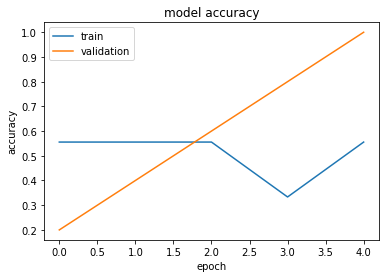

In [30]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 5  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)
plot_hist(hist)

In [42]:
size = (224, 224)

def _parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_bmp(img, channels = 3)
    img = tf.image.resize(img, size)
    img = tf.expand_dims(img, 0)
    return img

try_image_path =  
# try_image_path =  

try_image = _parse_image(try_image_path)

In [43]:
result = model.predict(try_image)
np.argmax(result) +1

2

In [44]:
result

array([[0.2592663 , 0.74073374]], dtype=float32)

In [16]:
# model.save('raw_complete')

In [17]:
model.save('normal_complete')

INFO:tensorflow:Assets written to: normal_complete\assets


In [18]:
# import tensorflow_datasets as tfds

# batch_size = 64

# dataset_name = "stanford_dogs"
# (ds_train, ds_test), ds_info = tfds.load(
#     dataset_name, split=["train", "test"], with_info=True, as_supervised=True
# )
# NUM_CLASSES = ds_info.features["label"].num_classes

In [19]:
# IMG_SIZE = 224

# size = (IMG_SIZE, IMG_SIZE)
# ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
# ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [20]:
# # One-hot / categorical encoding
# def input_preprocess(image, label):
#     label = tf.one_hot(label, NUM_CLASSES)
#     return image, label


# ds_train = ds_train.map(
#     input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
# )
# ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
# ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# ds_test = ds_test.map(input_preprocess)
# ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [21]:
# x = 0
# for i, a in ds_test:
#     if x < 1:
#         print(a.numpy()==1) 
#         print("-----")
#         x +=1
#     else:
#         break

In [22]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras import layers


# inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# model = tf.keras.Model(inputs, outputs)
# model.compile(
#         optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
#     )

# model.summary()

# epochs = 1  # @param {type: "slider", min:10, max:100}
# hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)